# PIGPVAE model

In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
from torch.utils.data import Dataset, DataLoader,random_split, Subset
from tqdm import tqdm
import tsgm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sys.path.append(os.path.abspath('..'))
from physics import NewtonsLaw
from GP import *

from Models.PIGPVAE_lognorm import PIGPVAE
from VAE_utils import AnnealingStrategy
import warnings
# Suppress only the specific GPInputWarning coming from the exact_gp.py file
warnings.filterwarnings(
    "ignore", 
    message="The input matches the stored training data. Did you forget to call model.train()?", 
    module=".*exact_gp"
)


In [2]:
# Import RICO data 
file_path = '../Data/RICO4_Dataset_processed.hdf'
df = pd.read_hdf(file_path)
#  define surrounding temperature
df.loc[:, 'sur_temp'] = (df['RTD420'] + df['RTD417'] + df['B.ASTRHT2.T'])/3 
df_h = df.copy()
df_h = df[df['temp_change_class'] == 'h']
def select_points(group):
    return group.iloc[::10]  # Select every 10th row
df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)
df_h = df_h.dropna()

/var/folders/46/30710m094qv2_dhfs08nzzd00000gn/T/ipykernel_6569/3580172856.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_h = df_h.groupby('Scheduler Step').apply(select_points).reset_index(drop=True)


In [3]:
class RICO4Dataset(Dataset):
    def __init__(self, df, select_var, exclude_samples=None):
        """
        Args:
            df: DataFrame containing the data.
            select_var: List of variables to include in the dataset.
            exclude_samples: List of samples (intervals) to exclude from the dataset.
        """
        self.df = df
        self.select_var = select_var
        if exclude_samples:
            self.unique_batches = [batch for batch in df['interval'].unique() if batch not in exclude_samples]
        else:
            self.unique_batches = df['interval'].unique()

    def __len__(self):
        return len(self.unique_batches)

    def __getitem__(self, idx):
        batch = self.unique_batches[idx]
        temp = self.df[self.df['interval'] == batch][self.select_var]
        
        # Normalize and convert to tensors
        ti = torch.tensor(temp['time_within_interval'].to_numpy() / 240, dtype=torch.float32)
        Ts = torch.tensor(temp['sur_temp'].to_numpy(), dtype=torch.float32)
        heat_obs = torch.tensor(temp['B.RTD1'].to_numpy(), dtype=torch.float32)
        
        # Stack the tensors to create the input batch
        x_batch = torch.stack((heat_obs, Ts, ti), dim=1)
        
        return x_batch

exclude_samples = [53, 5]
select_var = ['time_within_interval', 'sur_temp', 'B.RTD1']
dataset = RICO4Dataset(df_h, select_var, exclude_samples=exclude_samples)

# Validate the updated dataset
print(f"Dataset length after exclusion: {len(dataset)}")


# Define split ratios
train_ratio = 0.7
test_ratio = 1-train_ratio

total_size = len(dataset)
train_size = int(train_ratio * total_size)
test_size = total_size - train_size

seed = 0
generator = torch.Generator().manual_seed(seed)

train_subset, test_subset = random_split(
    dataset,
    [train_size, test_size],
    generator=generator
)
train_loader = DataLoader(train_subset, batch_size=1, shuffle=False)
val_loader = DataLoader(test_subset, batch_size=1, shuffle=False)

Dataset length after exclusion: 29


In [4]:
# Remove rows where 'interval' is 53 or 5 from df_h
excluded_intervals = [53, 5]
df_h_filtered = df_h[~df_h['interval'].isin(excluded_intervals)].reset_index(drop=True)
df_h = df_h_filtered


In [5]:
"""# Initialize lists to store train and validation data
train_time, train_heat = [], []
val_time, val_heat = [], []

# Collect data from train_loader
for batch in train_loader:
    # Extract `time_within_interval` and `B.RTD1` from each batch
    heat_obs = batch[0][:, 0].numpy()  # B.RTD1
    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale
    
    # Append to lists
    train_heat.extend(heat_obs)
    train_time.extend(time_within_interval)

# Collect data from val_loader
for batch in val_loader:
    # Extract `time_within_interval` and `B.RTD1` from each batch
    heat_obs = batch[0][:, 0].numpy()  # B.RTD1
    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale
    
    # Append to lists
    val_heat.extend(heat_obs)
    val_time.extend(time_within_interval)

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot training data with markers only
axes[0].scatter(train_time, train_heat, marker='o', label="Train Data", alpha=0.7)
axes[0].set_title("Train Data")
axes[0].set_xlabel("Time within Interval")
axes[0].set_ylabel("B.RTD1")
axes[0].legend()

# Plot validation data with markers only
axes[1].scatter(val_time, val_heat, marker='x', label="Validation Data", alpha=0.7, color='orange')
axes[1].set_title("Validation Data")
axes[1].set_xlabel("Time within Interval")
axes[1].legend()

plt.suptitle("B.RTD1 vs Time within Interval for Train and Validation Data")
plt.show()
"""

'# Initialize lists to store train and validation data\ntrain_time, train_heat = [], []\nval_time, val_heat = [], []\n\n# Collect data from train_loader\nfor batch in train_loader:\n    # Extract `time_within_interval` and `B.RTD1` from each batch\n    heat_obs = batch[0][:, 0].numpy()  # B.RTD1\n    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale\n    \n    # Append to lists\n    train_heat.extend(heat_obs)\n    train_time.extend(time_within_interval)\n\n# Collect data from val_loader\nfor batch in val_loader:\n    # Extract `time_within_interval` and `B.RTD1` from each batch\n    heat_obs = batch[0][:, 0].numpy()  # B.RTD1\n    time_within_interval = batch[0][:, 2].numpy() * 240  # Convert back to original scale\n    \n    # Append to lists\n    val_heat.extend(heat_obs)\n    val_time.extend(time_within_interval)\n\n# Create side-by-side plots\nfig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)\n\n# Plot training data with markers only\

In [6]:
kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5)) 

# Initialize the GP_inference
GP_inf = GP_inference(kernel)

torch.manual_seed(1)
model = PIGPVAE(GP_inf=GP_inf, 
                hidden_layers_encoder_delta=[10,10], 
                hidden_layers_encoder_phy=[10], 
                hidden_layers_decoder_delta=[10,10],
                activation_decoder_delta=nn.ELU(),
                initial_alpha=1.2,# initial_alpha=1,
                trainable_alpha=True,
                mu_prior=torch.tensor(1.7), var_prior=torch.tensor(1)
               )

In [7]:
gp_params = []
base_params = []
alpha_params = []

for name, param in model.named_parameters():
    if 'GP' in name:
        gp_params.append(param)  # Gaussian Process parameters
    elif 'raw_alpha' in name:
        alpha_params.append(param)  # raw_alpha parameter(s)
    else:
        base_params.append(param)  # All other parameters

# Define learning rates for each parameter group
base_lr = 0.001     # Learning rate for base parameters
gp_lr = 0.0001      # Learning rate for GP parameters
alpha_lr = 0.0001     # Learning rate for raw_alpha
# Create separate parameter groups in the optimizer
opt = torch.optim.Adam([
    {'params': base_params, 'lr': base_lr},
    {'params': gp_params, 'lr': gp_lr},
    {'params': alpha_params, 'lr': alpha_lr}
])
opt.zero_grad()


In [8]:
t_uni=torch.tensor(
    [  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101., 111.,
        121., 131., 141., 151., 161., 171., 181., 191., 201., 211., 221., 231.]
)


Training Progress:   5%|▍         | 11/240 [00:01<00:24,  9.47it/s]

Epoch 12: Train Loss = 2.8330, KL_phy = 2.5640, KL_delta = -0.3907, MSE = 2.7561, CE = 1.4898, Reg_Loss = 0.0461, Alpha = 1.1959
Validation Loss = 5.4995, Val_KL_phy = 2.5427, Val_KL_delta = -0.3822, Val_MSE = 5.3991, Val_CE = 1.4814, Val_Reg_Loss = 0.0659, Val_Alpha = 1.1957


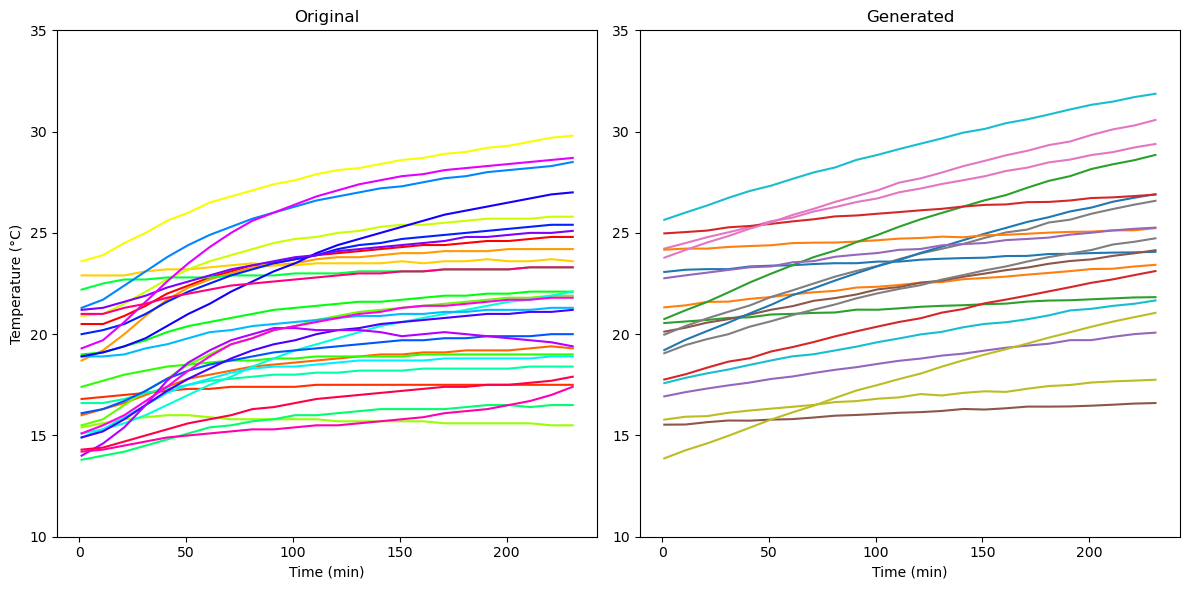

Training Progress:  10%|▉         | 23/240 [00:02<00:23,  9.35it/s]

Epoch 24: Train Loss = 2.7582, KL_phy = 2.4411, KL_delta = -0.1986, MSE = 2.6814, CE = 0.9599, Reg_Loss = 0.0457, Alpha = 1.1903
Validation Loss = 3.2243, Val_KL_phy = 2.4202, Val_KL_delta = -0.1882, Val_MSE = 3.1462, Val_CE = 0.9397, Val_Reg_Loss = 0.0469, Val_Alpha = 1.1900


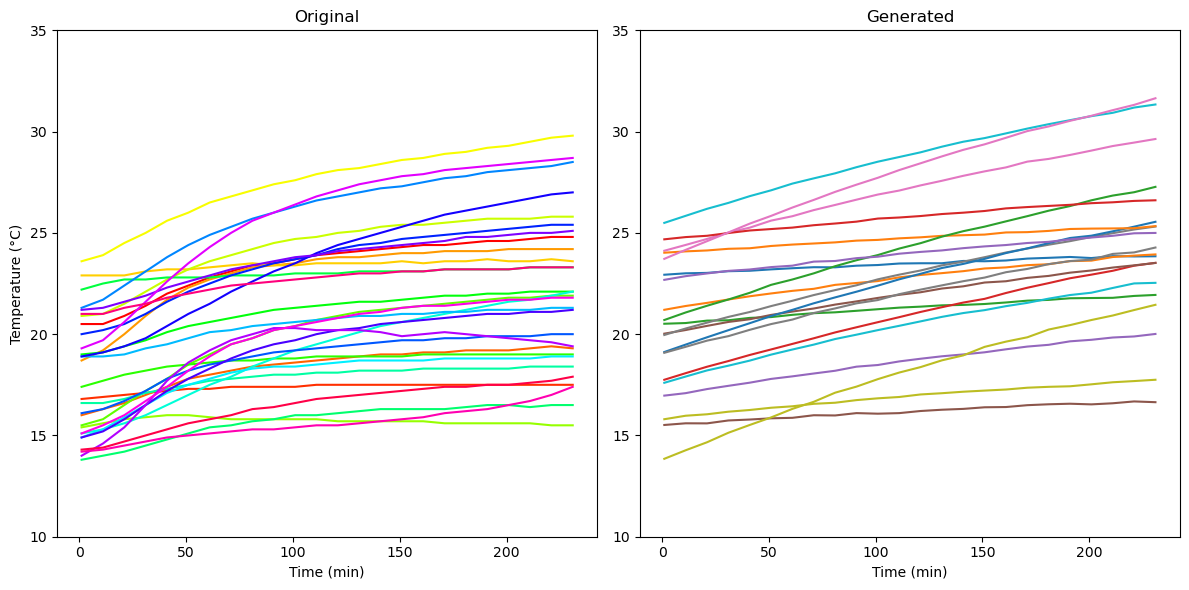

Training Progress:  15%|█▍        | 35/240 [00:04<00:22,  9.03it/s]

Epoch 36: Train Loss = 2.0944, KL_phy = 2.4794, KL_delta = 0.0581, MSE = 2.0303, CE = 0.6763, Reg_Loss = 0.0328, Alpha = 1.1832
Validation Loss = 4.6985, Val_KL_phy = 2.4445, Val_KL_delta = 0.1032, Val_MSE = 4.5790, Val_CE = 0.6556, Val_Reg_Loss = 0.0795, Val_Alpha = 1.1830


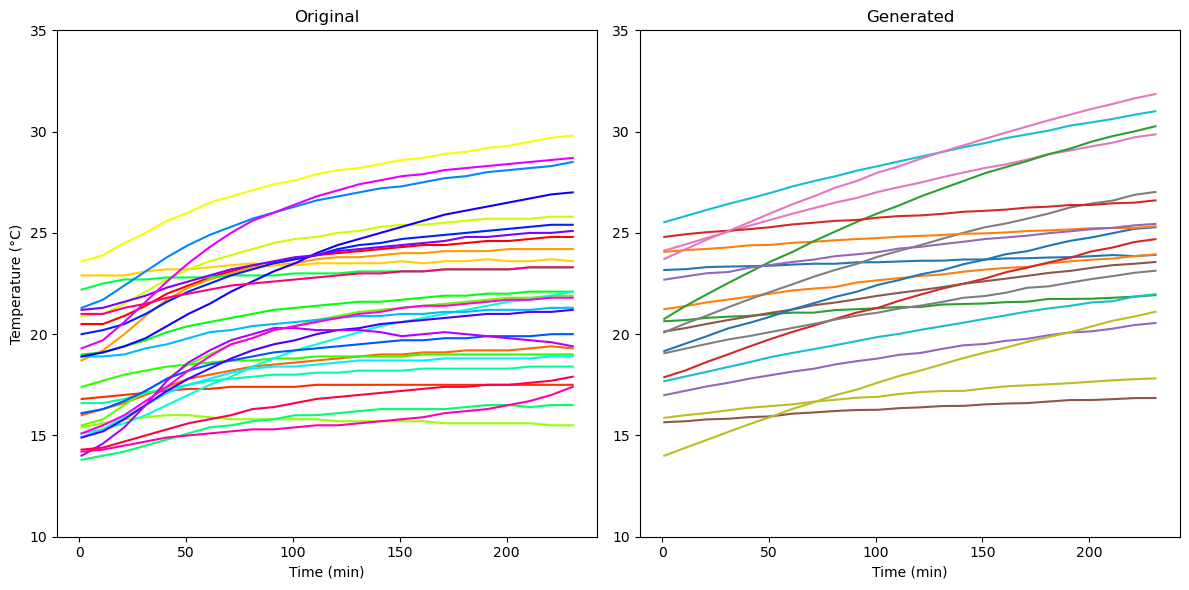

Training Progress:  20%|█▉        | 47/240 [00:05<00:20,  9.26it/s]

Epoch 48: Train Loss = 2.1753, KL_phy = 2.3220, KL_delta = 0.4174, MSE = 2.1019, CE = 0.4919, Reg_Loss = 0.0392, Alpha = 1.1742
Validation Loss = 3.1248, Val_KL_phy = 2.3037, Val_KL_delta = 0.4568, Val_MSE = 3.0265, Val_CE = 0.4574, Val_Reg_Loss = 0.0603, Val_Alpha = 1.1738


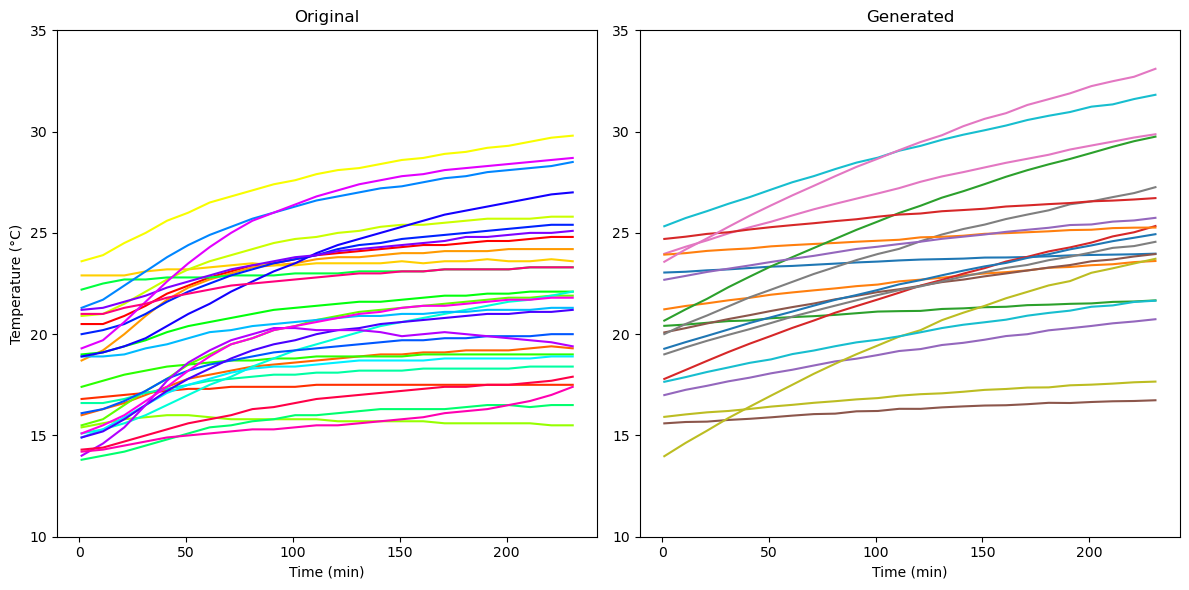

Training Progress:  25%|██▍       | 59/240 [00:07<00:19,  9.23it/s]

Epoch 60: Train Loss = 2.0017, KL_phy = 2.3111, KL_delta = 0.8825, MSE = 1.8997, CE = 0.5019, Reg_Loss = 0.0602, Alpha = 1.1626
Validation Loss = 2.5793, Val_KL_phy = 2.2982, Val_KL_delta = 0.9622, Val_MSE = 2.4493, Val_CE = 0.4733, Val_Reg_Loss = 0.0838, Val_Alpha = 1.1621


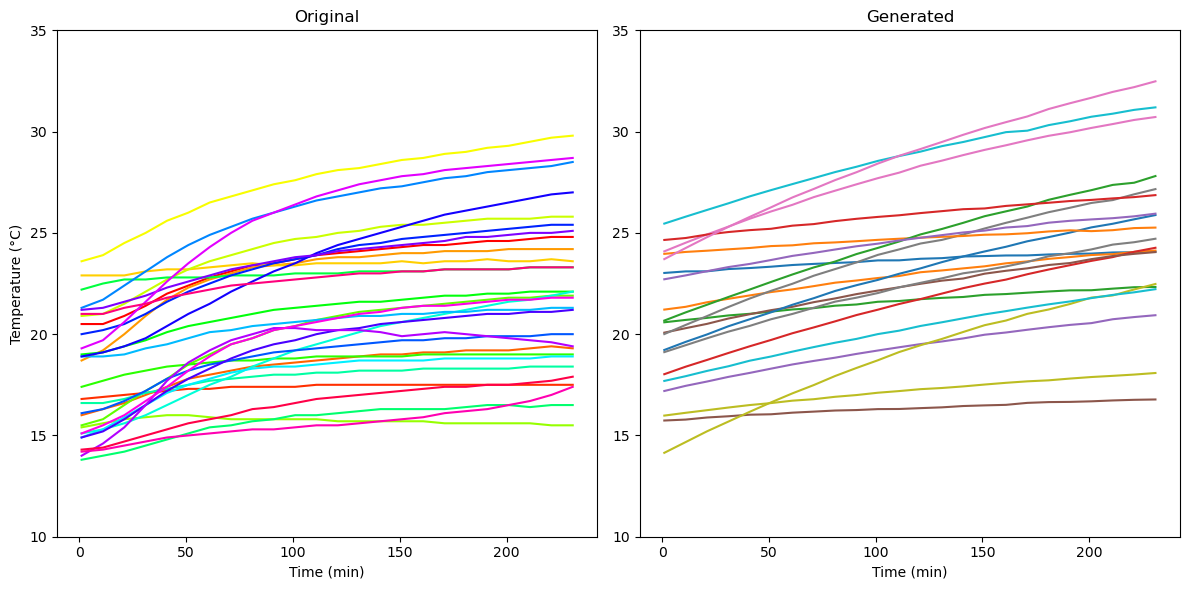

Training Progress:  30%|██▉       | 71/240 [00:08<00:19,  8.85it/s]

Epoch 72: Train Loss = 1.9604, KL_phy = 2.2999, KL_delta = 1.5901, MSE = 1.8438, CE = 0.3237, Reg_Loss = 0.0676, Alpha = 1.1486
Validation Loss = 2.9102, Val_KL_phy = 2.2833, Val_KL_delta = 1.6359, Val_MSE = 2.7545, Val_CE = 0.3595, Val_Reg_Loss = 0.1015, Val_Alpha = 1.1480


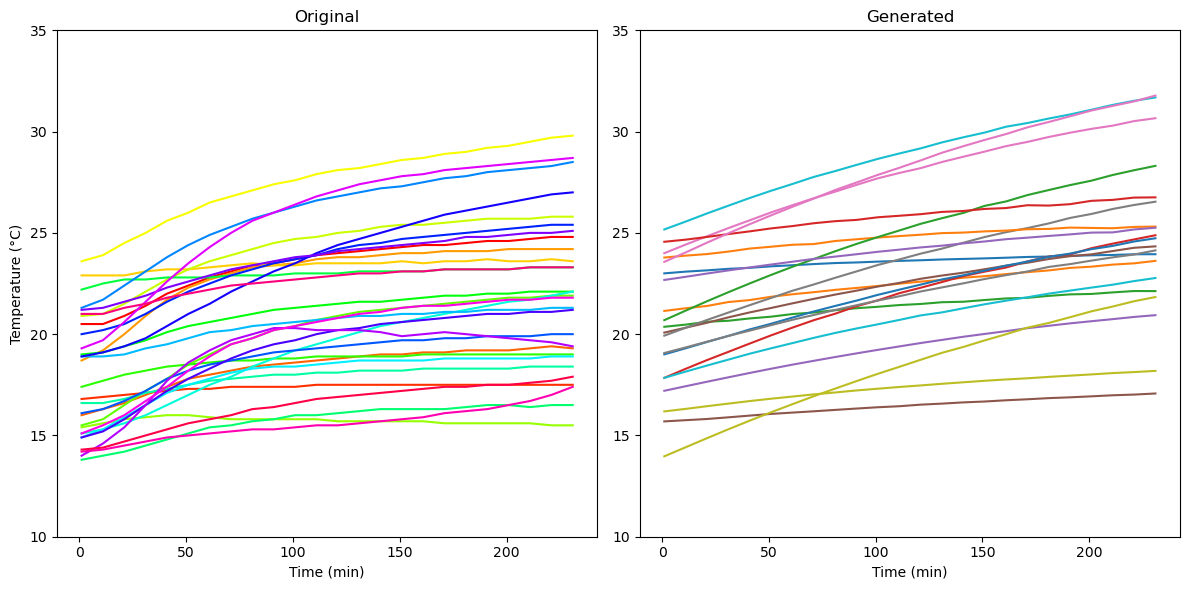

Training Progress:  35%|███▍      | 83/240 [00:09<00:17,  9.12it/s]

Epoch 84: Train Loss = 2.0535, KL_phy = 2.2437, KL_delta = 2.2940, MSE = 1.9095, CE = 0.2882, Reg_Loss = 0.0871, Alpha = 1.1327
Validation Loss = 3.2835, Val_KL_phy = 2.2199, Val_KL_delta = 2.3994, Val_MSE = 3.0777, Val_CE = 0.2561, Val_Reg_Loss = 0.1410, Val_Alpha = 1.1321


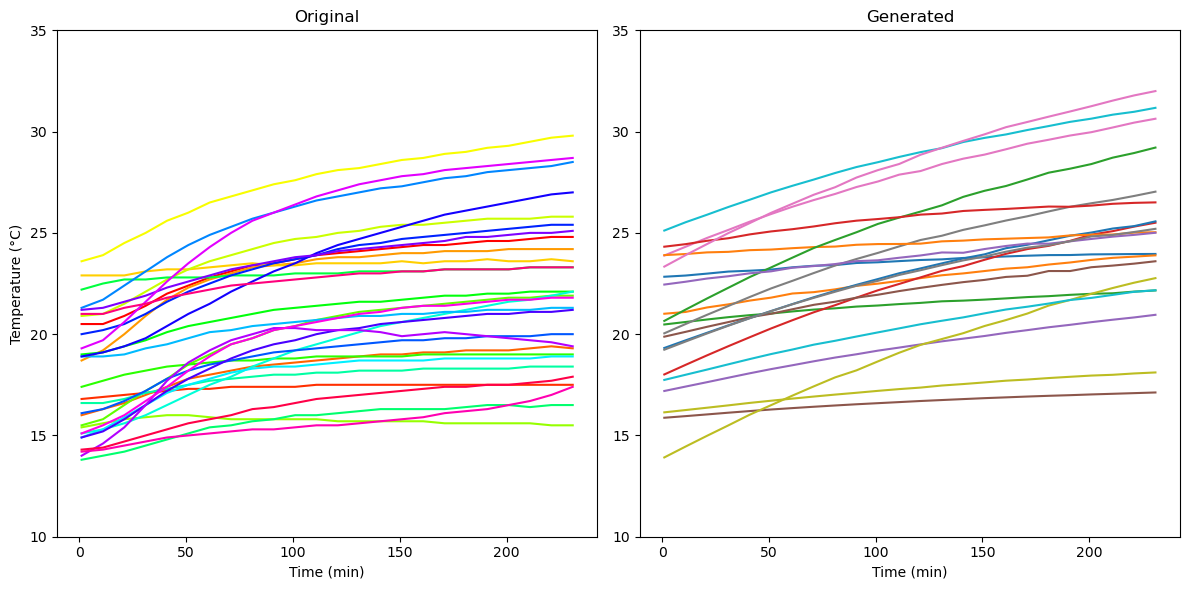

Training Progress:  40%|███▉      | 95/240 [00:11<00:18,  8.02it/s]

Epoch 96: Train Loss = 1.9608, KL_phy = 2.2107, KL_delta = 3.2330, MSE = 1.7765, CE = 0.1678, Reg_Loss = 0.1166, Alpha = 1.1139
Validation Loss = 3.0539, Val_KL_phy = 2.1851, Val_KL_delta = 3.3403, Val_MSE = 2.8019, Val_CE = 0.1561, Val_Reg_Loss = 0.1767, Val_Alpha = 1.1132


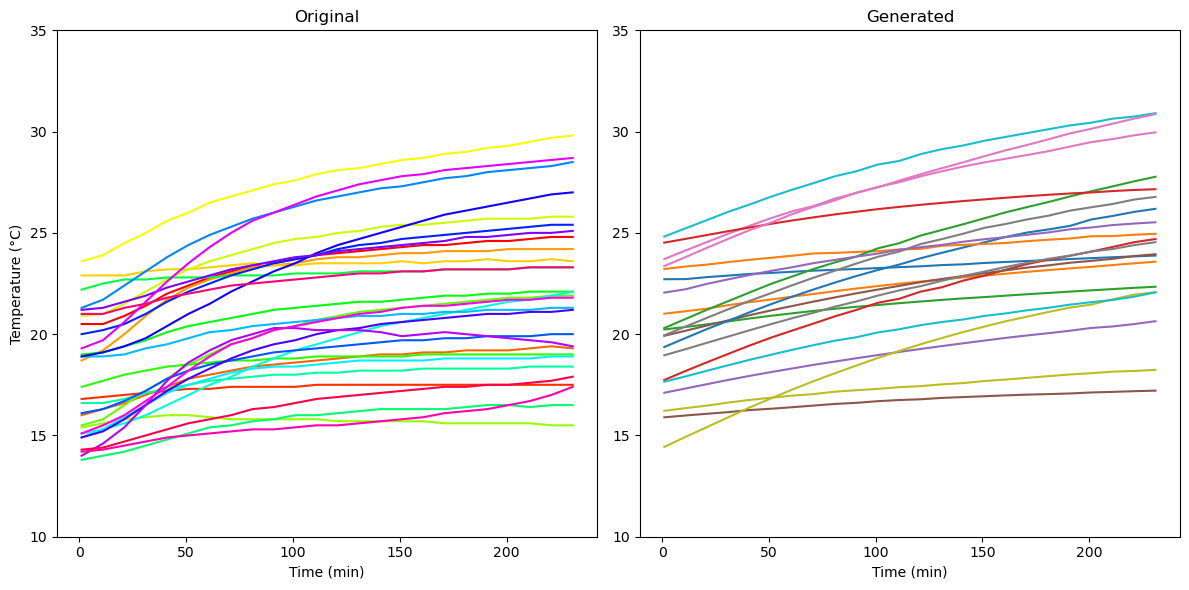

Training Progress:  45%|████▍     | 107/240 [00:12<00:14,  8.90it/s]

Epoch 108: Train Loss = 1.9859, KL_phy = 2.2586, KL_delta = 4.2171, MSE = 1.7095, CE = 0.1672, Reg_Loss = 0.1937, Alpha = 1.0925
Validation Loss = 2.2946, Val_KL_phy = 2.2458, Val_KL_delta = 4.2843, Val_MSE = 1.9762, Val_CE = 0.1685, Val_Reg_Loss = 0.2319, Val_Alpha = 1.0916


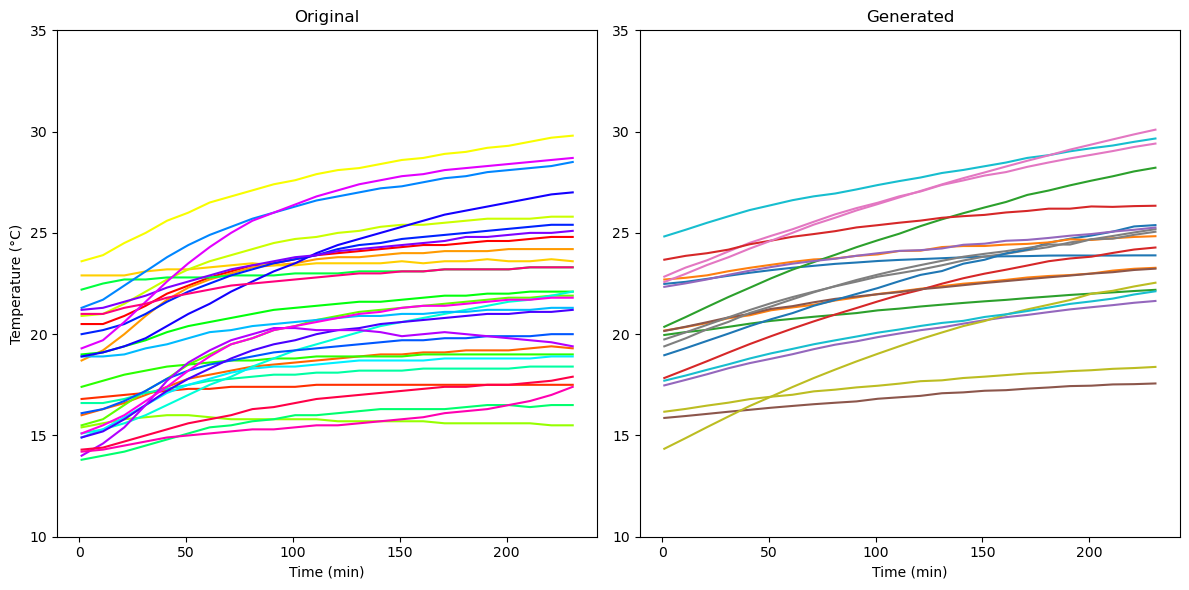

Training Progress:  50%|████▉     | 119/240 [00:14<00:13,  9.25it/s]

Epoch 120: Train Loss = 1.5817, KL_phy = 2.2588, KL_delta = 5.2144, MSE = 1.2489, CE = 0.1822, Reg_Loss = 0.2414, Alpha = 1.0691
Validation Loss = 2.2872, Val_KL_phy = 2.2477, Val_KL_delta = 5.2954, Val_MSE = 1.8265, Val_CE = 0.1861, Val_Reg_Loss = 0.3606, Val_Alpha = 1.0681


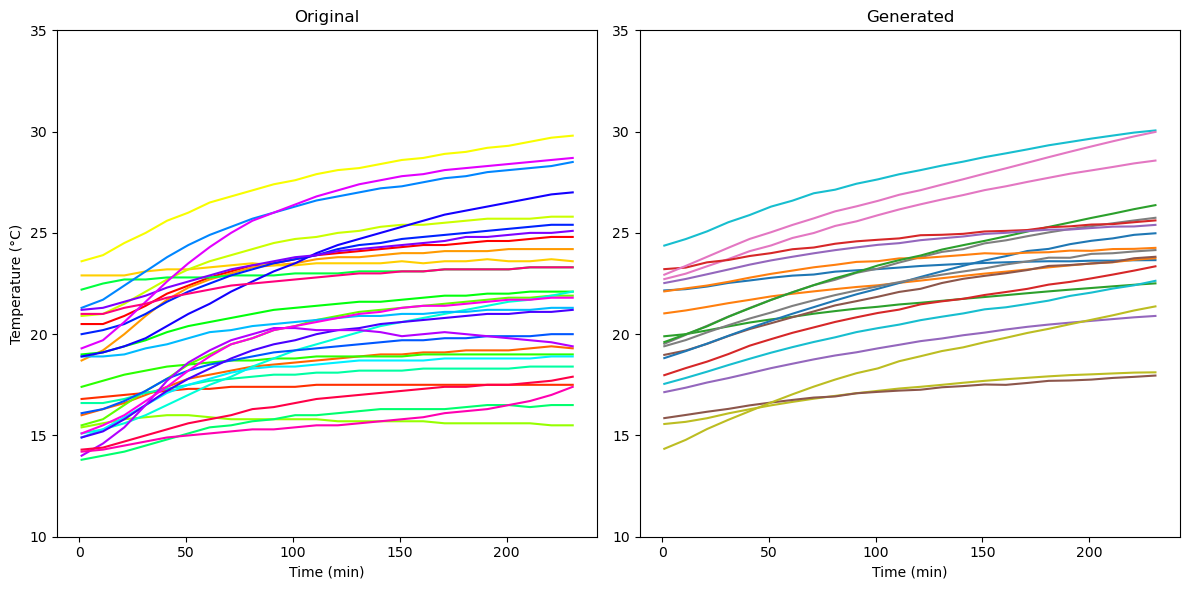

Training Progress:  55%|█████▍    | 131/240 [00:15<00:11,  9.12it/s]

Epoch 132: Train Loss = 1.5724, KL_phy = 2.2958, KL_delta = 6.1037, MSE = 1.1150, CE = 0.2115, Reg_Loss = 0.3568, Alpha = 1.0467
Validation Loss = 1.8694, Val_KL_phy = 2.3050, Val_KL_delta = 6.1368, Val_MSE = 1.3574, Val_CE = 0.2122, Val_Reg_Loss = 0.4088, Val_Alpha = 1.0458


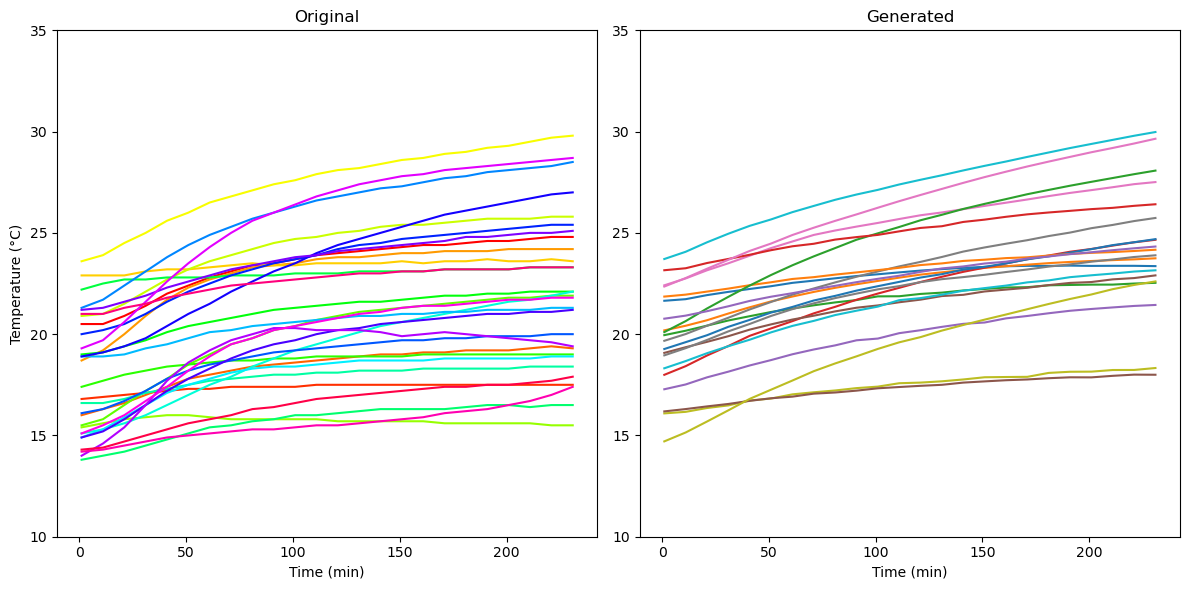

Training Progress:  60%|█████▉    | 143/240 [00:17<00:11,  8.63it/s]

Epoch 144: Train Loss = 1.4308, KL_phy = 2.2530, KL_delta = 6.6848, MSE = 0.9076, CE = 0.2305, Reg_Loss = 0.4230, Alpha = 1.0256
Validation Loss = 1.8616, Val_KL_phy = 2.2435, Val_KL_delta = 6.5966, Val_MSE = 1.1390, Val_CE = 0.2285, Val_Reg_Loss = 0.6189, Val_Alpha = 1.0248


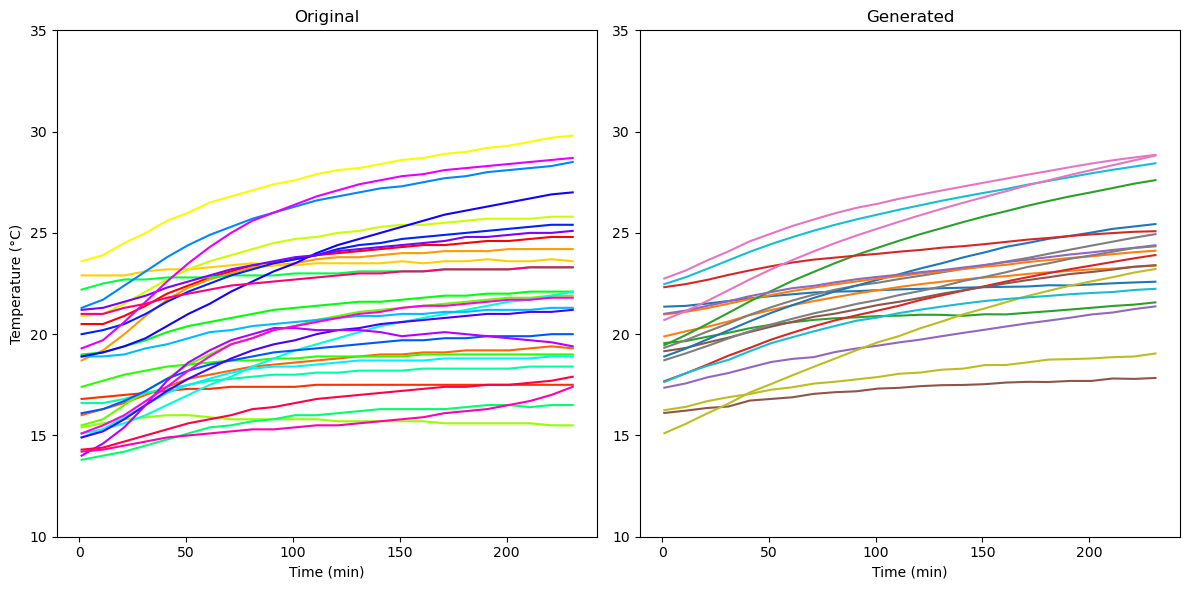

Training Progress:  65%|██████▍   | 155/240 [00:18<00:09,  9.39it/s]

Epoch 156: Train Loss = 1.3619, KL_phy = 2.3272, KL_delta = 7.0335, MSE = 0.7910, CE = 0.2434, Reg_Loss = 0.4741, Alpha = 1.0067
Validation Loss = 1.4872, Val_KL_phy = 2.3257, Val_KL_delta = 6.9013, Val_MSE = 0.8383, Val_CE = 0.2405, Val_Reg_Loss = 0.5533, Val_Alpha = 1.0060


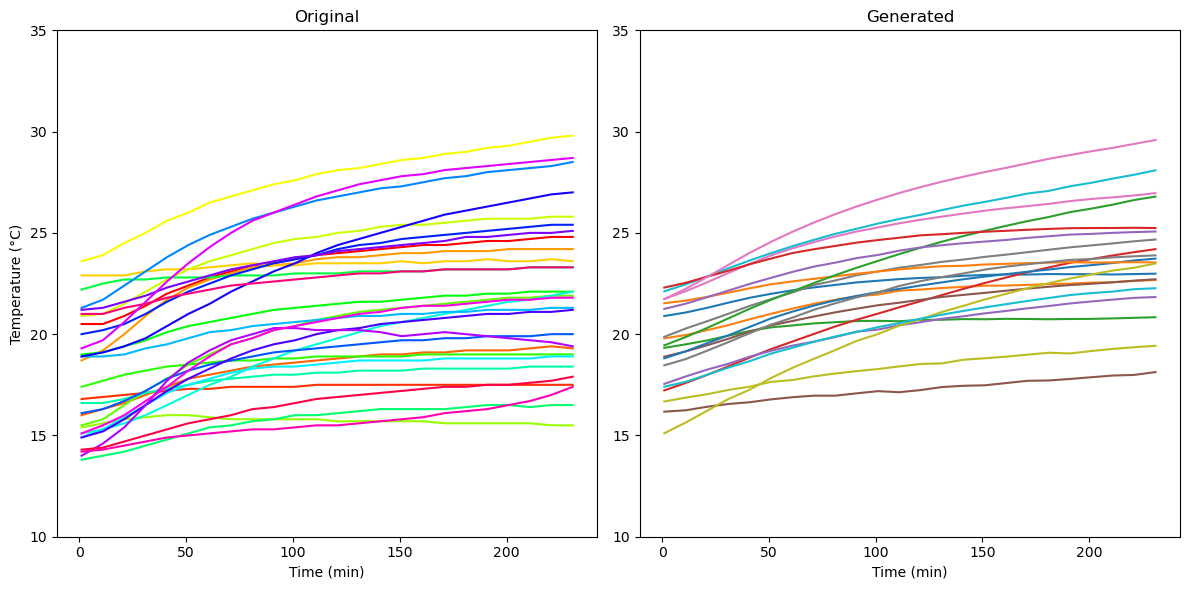

Training Progress:  70%|██████▉   | 167/240 [00:20<00:07,  9.20it/s]

Epoch 168: Train Loss = 1.2459, KL_phy = 2.3343, KL_delta = 7.0795, MSE = 0.6833, CE = 0.2478, Reg_Loss = 0.4733, Alpha = 0.9898
Validation Loss = 1.6203, Val_KL_phy = 2.3178, Val_KL_delta = 6.9185, Val_MSE = 0.8872, Val_CE = 0.2426, Val_Reg_Loss = 0.6477, Val_Alpha = 0.9893


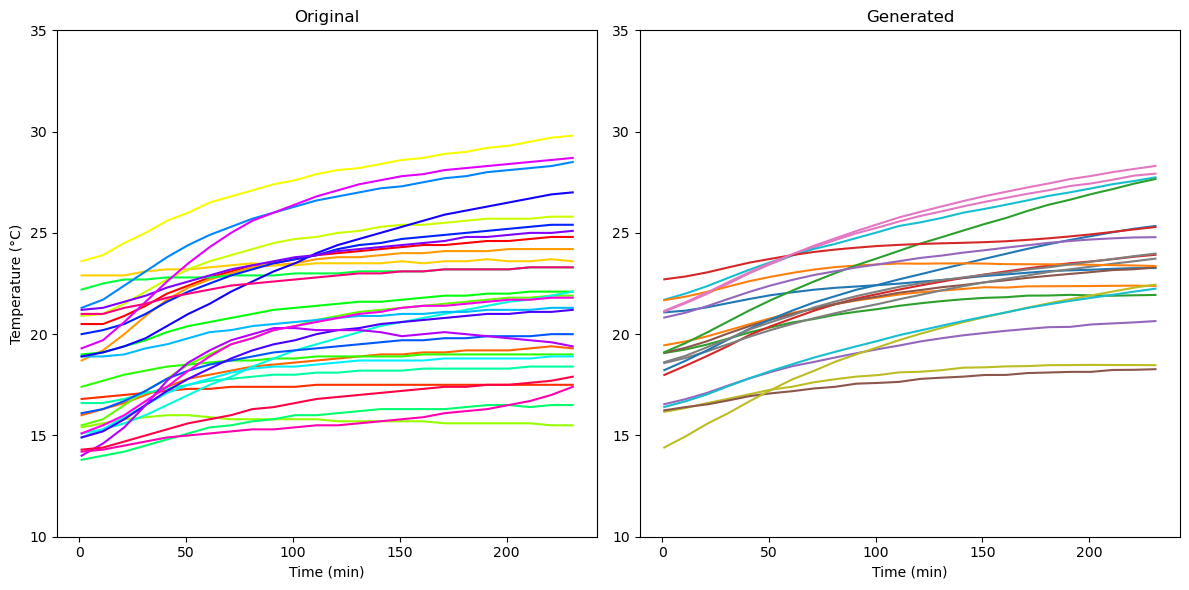

Training Progress:  75%|███████▍  | 179/240 [00:21<00:06,  9.09it/s]

Epoch 180: Train Loss = 1.1236, KL_phy = 2.3350, KL_delta = 7.0380, MSE = 0.5935, CE = 0.2498, Reg_Loss = 0.4473, Alpha = 0.9757
Validation Loss = 1.7401, Val_KL_phy = 2.3201, Val_KL_delta = 6.8904, Val_MSE = 0.9595, Val_CE = 0.2448, Val_Reg_Loss = 0.7061, Val_Alpha = 0.9752


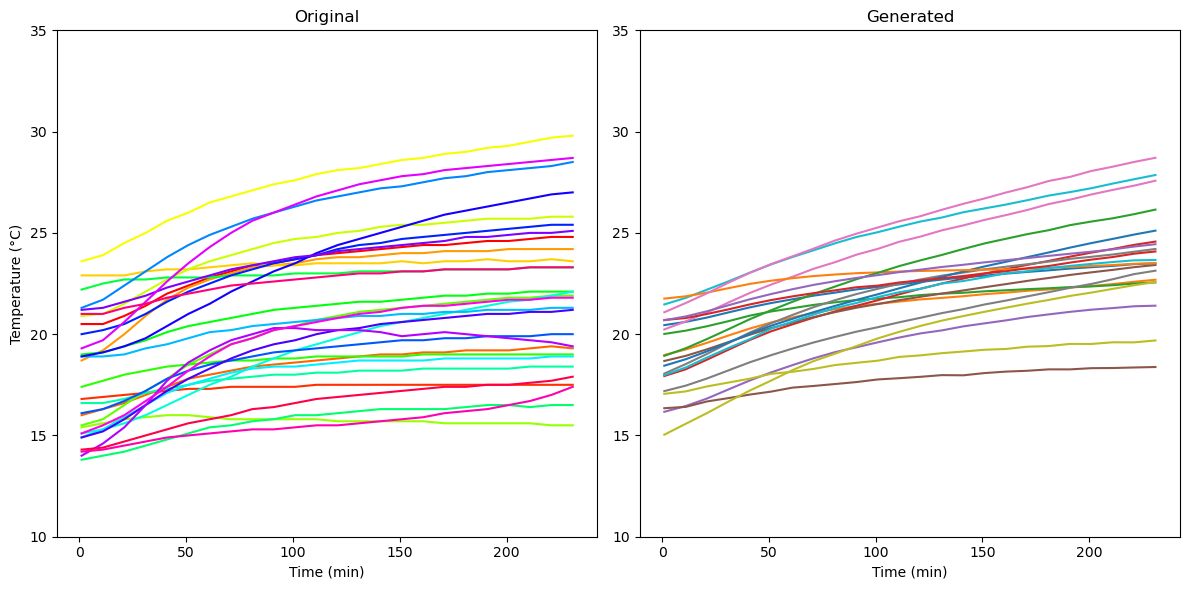

Training Progress:  80%|███████▉  | 191/240 [00:23<00:05,  9.22it/s]

Epoch 192: Train Loss = 1.2475, KL_phy = 2.3692, KL_delta = 6.8438, MSE = 0.6565, CE = 0.2449, Reg_Loss = 0.5187, Alpha = 0.9618
Validation Loss = 1.6587, Val_KL_phy = 2.3540, Val_KL_delta = 6.6935, Val_MSE = 0.9201, Val_CE = 0.2386, Val_Reg_Loss = 0.6742, Val_Alpha = 0.9612


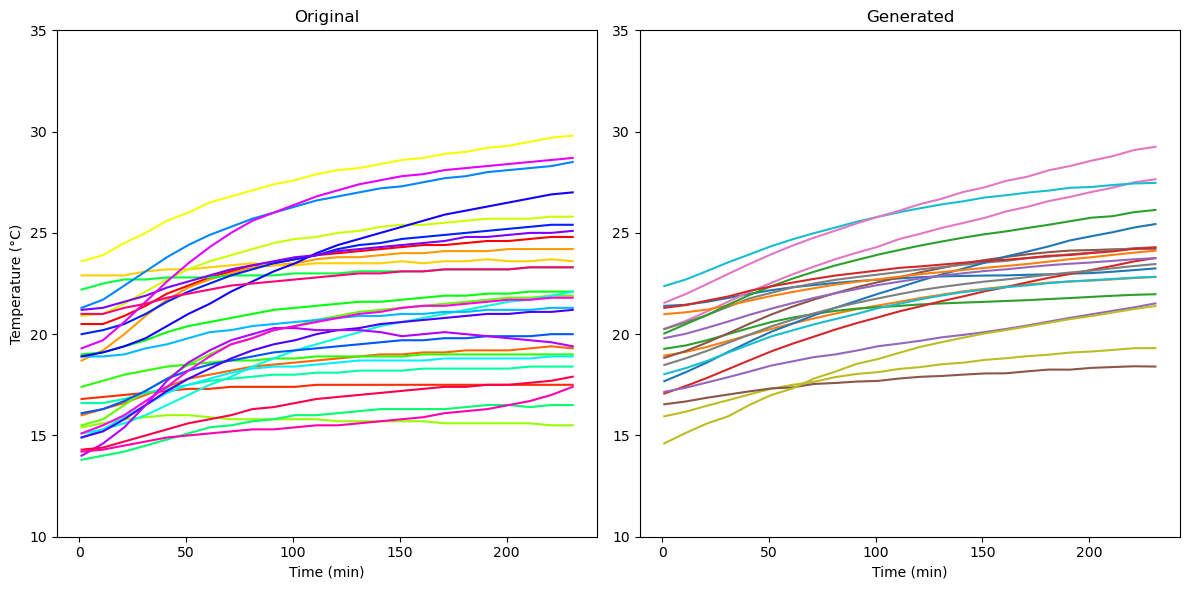

Training Progress:  85%|████████▍ | 203/240 [00:24<00:03,  9.25it/s]

Epoch 204: Train Loss = 1.2222, KL_phy = 2.3729, KL_delta = 6.6385, MSE = 0.6358, CE = 0.2447, Reg_Loss = 0.5230, Alpha = 0.9489
Validation Loss = 1.5958, Val_KL_phy = 2.3838, Val_KL_delta = 6.5149, Val_MSE = 0.8537, Val_CE = 0.2279, Val_Reg_Loss = 0.6887, Val_Alpha = 0.9484


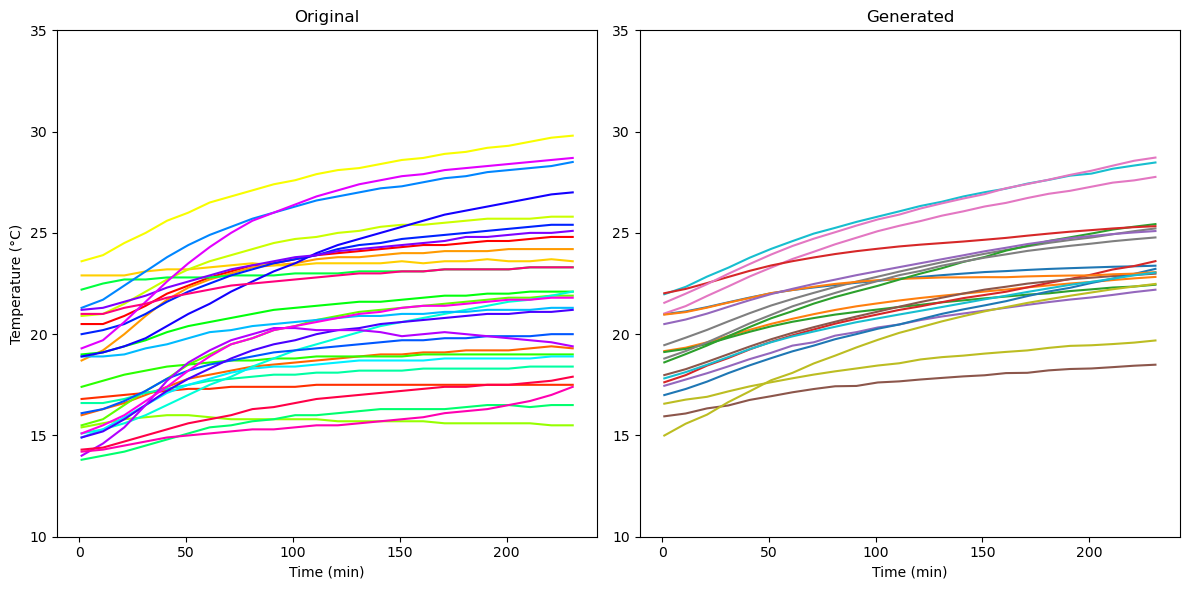

Training Progress:  90%|████████▉ | 215/240 [00:26<00:02,  9.24it/s]

Epoch 216: Train Loss = 1.2888, KL_phy = 2.4050, KL_delta = 6.4967, MSE = 0.6863, CE = 0.2379, Reg_Loss = 0.5481, Alpha = 0.9367
Validation Loss = 1.5788, Val_KL_phy = 2.3918, Val_KL_delta = 6.3389, Val_MSE = 0.7973, Val_CE = 0.2245, Val_Reg_Loss = 0.7414, Val_Alpha = 0.9363


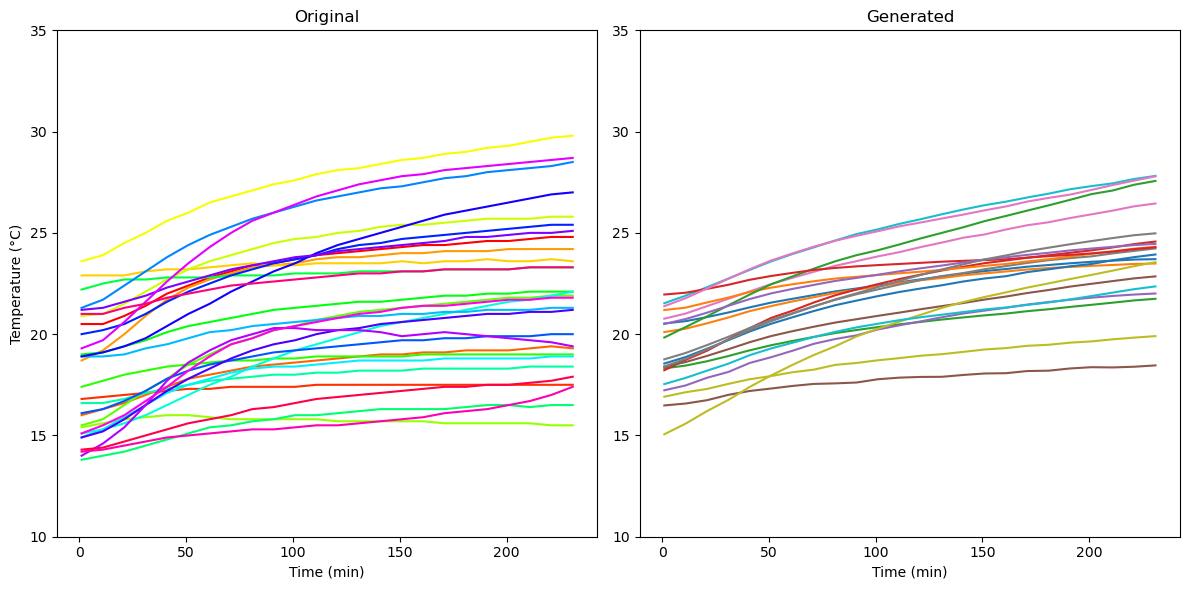

Training Progress:  95%|█████████▍| 227/240 [00:27<00:01,  9.22it/s]/Users/michailspitieris/anaconda3/envs/RICO/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Epoch 228: Train Loss = 1.1952, KL_phy = 2.4331, KL_delta = 6.3441, MSE = 0.6096, CE = 0.2316, Reg_Loss = 0.5383, Alpha = 0.9248
Validation Loss = 1.6630, Val_KL_phy = 2.4208, Val_KL_delta = 6.1955, Val_MSE = 0.8751, Val_CE = 0.2261, Val_Reg_Loss = 0.7591, Val_Alpha = 0.9243


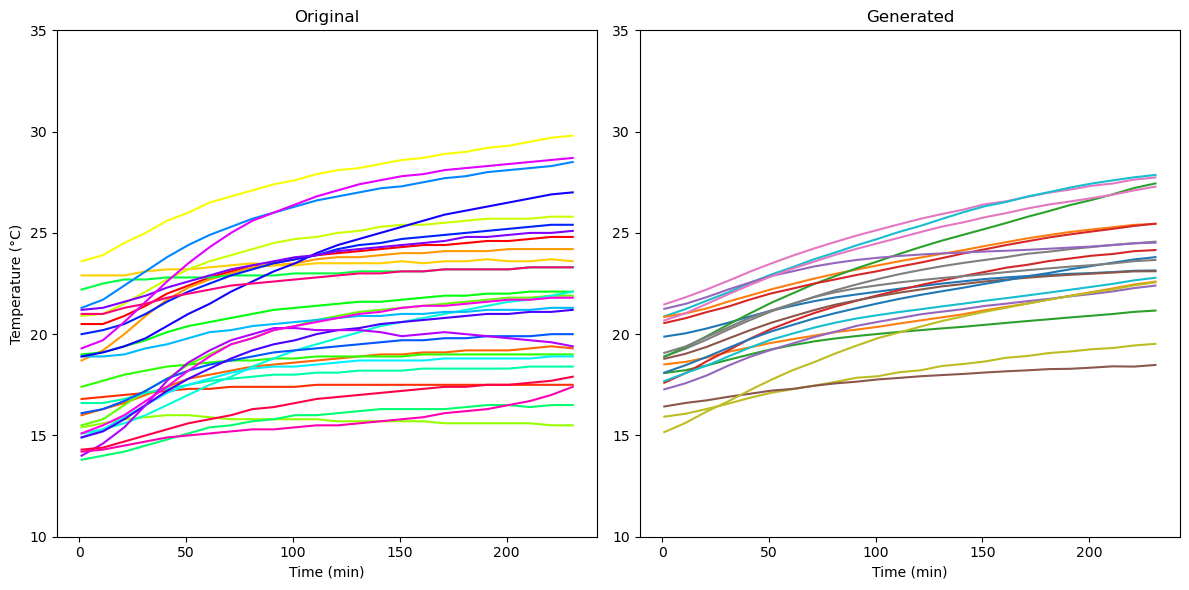

Training Progress: 100%|█████████▉| 239/240 [00:29<00:00,  8.96it/s]

Epoch 240: Train Loss = 1.1489, KL_phy = 2.4855, KL_delta = 6.1522, MSE = 0.6046, CE = 0.2264, Reg_Loss = 0.5015, Alpha = 0.9132
Validation Loss = 1.5017, Val_KL_phy = 2.4578, Val_KL_delta = 6.0284, Val_MSE = 0.7597, Val_CE = 0.2201, Val_Reg_Loss = 0.7200, Val_Alpha = 0.9128


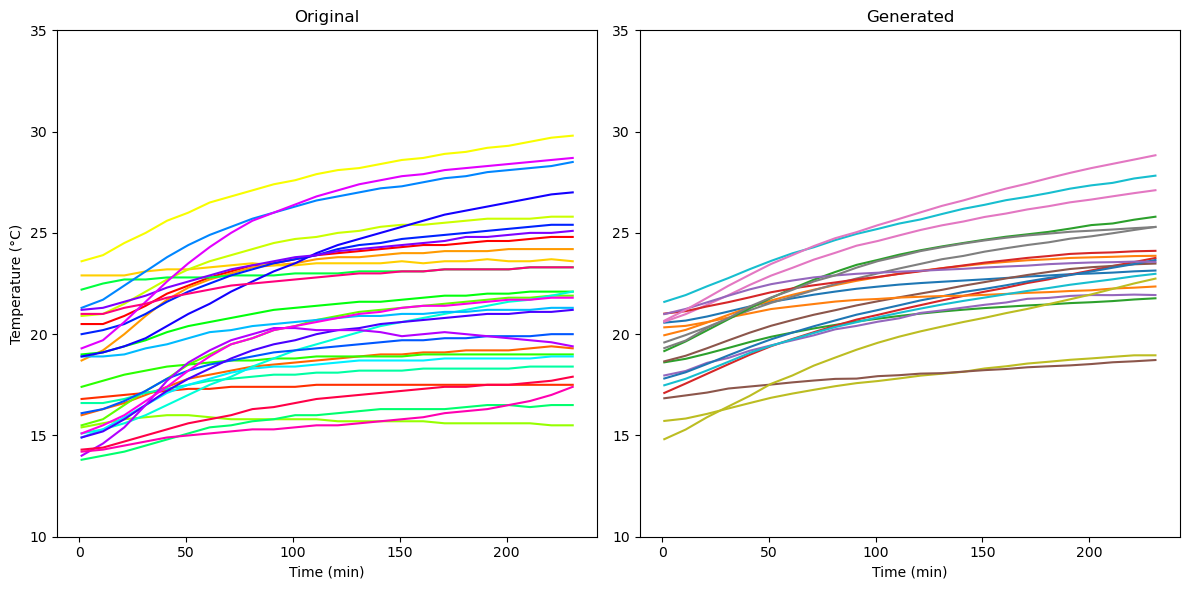

Training Progress: 100%|██████████| 240/240 [00:29<00:00,  8.21it/s]


In [9]:
num_epochs=240
epochs=range(num_epochs)

annealing_strategy = AnnealingStrategy(strategy='linear', 
                                       total_epochs=num_epochs, 
                                       beta_min=0.01, 
                                       beta_max=0.01)
beta_annealed = annealing_strategy.get_beta_vector()

beta_delta=beta_annealed
beta_phy=beta_annealed
ns = 20
min_T, max_T = 12, 25
T0 = min_T + (max_T - min_T) * torch.rand(ns)
difference = 1 + (20 - 1) * torch.rand(ns)
Ts = T0 + difference
unique_intervals = df_h['interval'].unique()
num_unique_intervals = len(unique_intervals)

fit_res = model.fit(train_loader=train_loader, 
                    val_loader=val_loader, 
                    opt=opt, 
                    beta_delta=beta_delta,
                    beta_phy=beta_phy,
                    num_epochs=num_epochs,
                   seed=0, plot=True, df=df_h, ns=ns, T0=T0, Ts=Ts, t_uni=t_uni/240, axs_ylim=(10, 35))


In [10]:
fit_res['alpha_values'][-1]

0.913195988535881

In [11]:
torch.save(model.state_dict(), 'pre_trained_models/PIGPVAE_heating.pth')